In [1]:
import os
import dill
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullLocator
from matplotlib.lines import Line2D


from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter, LogFormatter

import sys
sys.path.insert(0, '../../../src')

from biae import BayesianIQAEResult

In [2]:
# Create a loglog plot for 
theta = 45

In [3]:
# Load variables
file_path = os.path.join('../all_angle_results', f'results_{theta}.pkl')
with open(file_path, 'rb') as f:
    data_loaded = dill.load(f)



In [4]:
p = data_loaded['p']
R = len(data_loaded['results_bayes'][0]['results'])
results_jeff = []   #Beta-IQAE
results_bayes = []  #Beta-BIQAE

for method in ['results_bayes', 'results_jeff']:
    for i in range(len(data_loaded[method])):   # iterate over epsilons
        epsilon_target = data_loaded[method][i]['epsilon']
        num_correct = 0
        N_oracles = []
        for j in range(R):
            iae_result = data_loaded[method][i]['results'][j]
            ci = iae_result.confidence_interval
            if ci[0] <= p and ci[1] >= p and (ci[1] - ci[0]) < 2 * epsilon_target:
                num_correct += 1
            N_oracles.append(iae_result.num_oracle_queries)
        proportion_correct = num_correct / R
        N_oracles_array = np.array(N_oracles)
        result = {
            'epsilon': epsilon_target,
            'proportion_correct': proportion_correct,
            'average_N_oracles': np.mean(N_oracles_array),
            'std_N_oracles': np.std(N_oracles_array)
        }
        if method == 'results_bayes':
            results_bayes.append(result)
        else:
            results_jeff.append(result)


### Scaling Plot

In [5]:
start_index = 1

# Extract epsilon and average_N_oracle data
epsilon_bayes = [res['epsilon'] for res in results_bayes][start_index:]
average_N_oracle_bayes = [res['average_N_oracles'] for res in results_bayes][start_index:]

epsilon_jeff = [res['epsilon'] for res in results_jeff][start_index:]
average_N_oracle_jeff = [res['average_N_oracles'] for res in results_jeff][start_index:]

# Calculate the ratio of improvement
improvement = [(1 - b / j) * 100 for b, j in zip(average_N_oracle_bayes, average_N_oracle_jeff)]

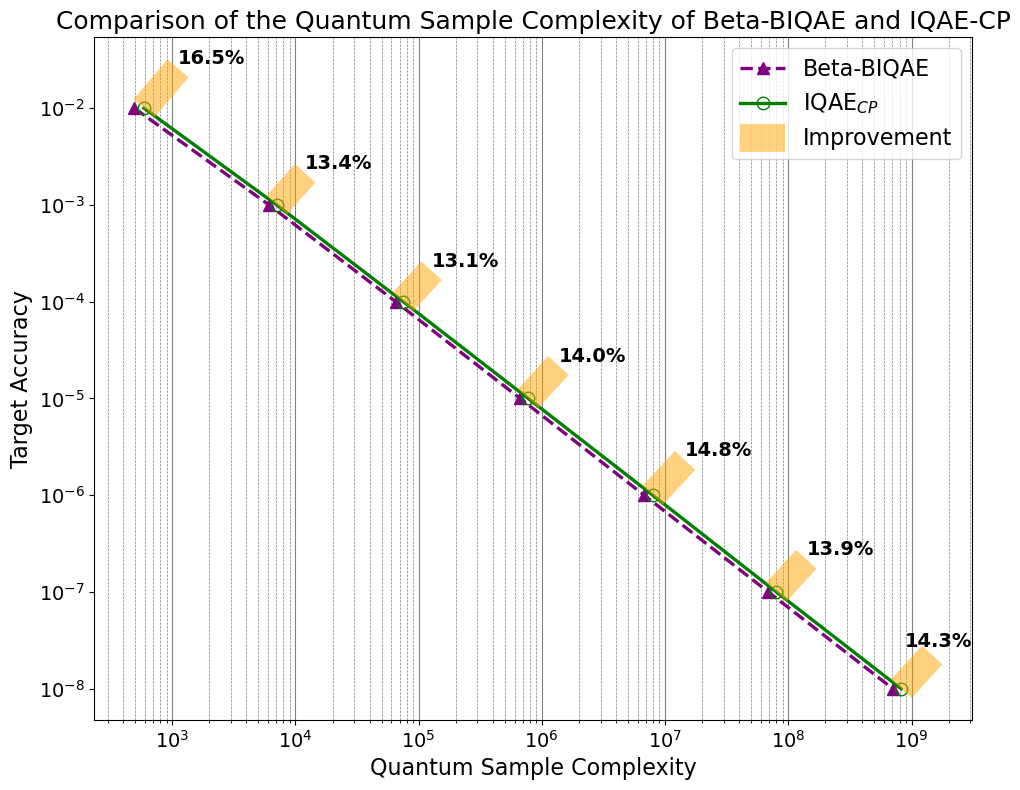

In [6]:
# Create figure
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot the main lines
ax1.plot(average_N_oracle_bayes, epsilon_bayes, '^--', color='purple', label='Beta-BIQAE', markersize=9, linewidth=2.4)
line_jeff = ax1.plot(average_N_oracle_jeff, epsilon_jeff, 'o-', color='green', label='IQAE$_{CP}$', markersize=9, markerfacecolor='none', linewidth=2.4)[0]

# Set logarithmic scale for both axes
ax1.set_xscale('log')
ax1.set_yscale('log')

# Customizing the log scale ticks
x_major_locator = LogLocator(base=10.0, subs=[1.0], numticks=10)
x_minor_locator = LogLocator(base=10.0, subs=np.linspace(2, 9, 8), numticks=10)
y_locator = LogLocator(base=10.0)
y_minor_locator = NullLocator()

ax1.xaxis.set_major_locator(x_major_locator)
ax1.xaxis.set_minor_locator(x_minor_locator)
ax1.yaxis.set_major_locator(y_locator)
ax1.yaxis.set_minor_locator(y_minor_locator)

# Set labels and title
ax1.set_xlabel('Quantum Sample Complexity', fontsize=16)
ax1.set_ylabel('Target Accuracy', fontsize=16)
ax1.set_title('Comparison of the Quantum Sample Complexity of Beta-BIQAE and IQAE-CP', fontsize=18)

# Increase font size for tick labels
ax1.tick_params(axis='both', which='major', labelsize=14)

# Add grid lines for x-axis only
ax1.grid(which='both', axis='both', linestyle='', linewidth=0)
ax1.grid(which='major', axis='x', linestyle='-', color='gray', linewidth=0.8)
ax1.grid(which='minor', axis='x', linestyle='--', color='gray', linewidth=0.5)

# Calculate slopes for the green line in log-log space
log_x_jeff = np.log10(average_N_oracle_jeff)
log_y_jeff = np.log10(epsilon_jeff)

# Create thick bar chart using simpler method - using standard matplotlib approach
for i in range(len(log_x_jeff)):
    # Get current point
    x = average_N_oracle_jeff[i]
    y = epsilon_jeff[i]
    imp = improvement[i]
    
    # Calculate slope of green line at this point (log-log space)
    if i < len(log_x_jeff) - 1:
        dx = log_x_jeff[i+1] - log_x_jeff[i]
        dy = log_y_jeff[i+1] - log_y_jeff[i]
    else:
        dx = log_x_jeff[i] - log_x_jeff[i-1]
        dy = log_y_jeff[i] - log_y_jeff[i-1]
    
    if dx != 0:
        slope = dy / dx
    else:
        slope = float('inf')
    
    # Calculate perpendicular slope
    if slope != 0:
        perp_slope = -1 / slope
    else:
        perp_slope = float('inf')
    
    # Calculate bar endpoint
    bar_length = imp / 100 * 3 # Adjust length based on improvement percentage
    angle = np.arctan(perp_slope) + np.pi/2 * 0.1
    dx_log = bar_length * np.cos(angle)
    dy_log = bar_length * np.sin(angle)

    
    # Calculate endpoint
    end_x = x * (10 ** dx_log)
    end_y = y * (10 ** dy_log)
    
    # Use very thick lines to simulate bar chart, which may work better in log space
    ax1.plot([x, end_x], [y, end_y], color='orange', linewidth=20, solid_capstyle='butt', alpha=0.5)
    
    # Add percentage labels, adjust position for the last point
    if i == len(log_x_jeff) - 1:
        # Offset the label for the last point slightly to the left to avoid going off the chart
        ax1.text(end_x * 0.6, end_y * 1.1, f'{imp:.1f}%', 
                ha='left', va='bottom', fontsize=14, fontweight='bold')
    else:
        ax1.text(end_x, end_y, f'{imp:.1f}%', 
                ha='left', va='bottom', fontsize=14, fontweight='bold')

# Add a sample object for the legend - reduce line length
ax1.plot([], [], color='orange', linewidth=20, solid_capstyle='butt', label='Improvement', alpha=0.5, markersize=5)

# Add legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=16, loc='upper right')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f'loglog_plot_{theta}_on_line.png', bbox_inches='tight', dpi=300)

# Show plot
plt.show()

### Generate the LaTex table.

In [7]:
def scientific_notation(number):
    """Convert a number to scientific notation in LaTeX format."""
    if number == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(number))))
    mantissa = number / 10**exponent
    return f"{mantissa:.2f} \\times 10^{{{exponent}}}"

# Start of the LaTeX table
latex_code = """\\begin{table}[h!]
\\centering
\\begin{tabular}{c|c|c|c}
\\hline
\\textbf{Epsilon} & \\textbf{Beta-BIQAE} & \\textbf{IQAE} & \\textbf{Improvement} \\\\ \\hline
"""

# Generate rows
for bayes, jeff in zip(results_bayes, results_jeff):
    epsilon = bayes['epsilon']
    bayes_mean = bayes['average_N_oracles']
    bayes_std = bayes['std_N_oracles']
    jeff_mean = jeff['average_N_oracles']
    jeff_std = jeff['std_N_oracles']
    
    # Calculate improvement percentage
    improvement = (1 - bayes_mean/jeff_mean) * 100
    
    # Format the row
    row = f"${scientific_notation(epsilon)}$ & "
    row += f"${scientific_notation(bayes_mean)} \\,({scientific_notation(bayes_std)})$ & "
    row += f"${scientific_notation(jeff_mean)} \\,({scientific_notation(jeff_std)})$ & "
    row += f"${improvement:.2f}$ \\% \\\\\n"
    
    latex_code += row

# End of the LaTeX table
latex_code += """\\hline
\\end{tabular}
\\caption{Complexity comparison of Bayesian IQAE and IQAE. The format for Bayesian IQAE and IQAE columns is mean (standard deviation).}
\\label{tab:iqae_comparison}
\\end{table}"""

print(latex_code)

\begin{table}[h!]
\centering
\begin{tabular}{c|c|c|c}
\hline
\textbf{Epsilon} & \textbf{Beta-BIQAE} & \textbf{IQAE} & \textbf{Improvement} \\ \hline
$1.00 \times 10^{-1}$ & $1.99 \times 10^{1} \,(7.65 \times 10^{0})$ & $2.00 \times 10^{1} \,(0)$ & $0.75$ \% \\
$1.00 \times 10^{-2}$ & $4.93 \times 10^{2} \,(8.60 \times 10^{1})$ & $5.90 \times 10^{2} \,(7.91 \times 10^{1})$ & $16.51$ \% \\
$1.00 \times 10^{-3}$ & $6.10 \times 10^{3} \,(1.01 \times 10^{3})$ & $7.04 \times 10^{3} \,(1.02 \times 10^{3})$ & $13.37$ \% \\
$1.00 \times 10^{-4}$ & $6.51 \times 10^{4} \,(1.07 \times 10^{4})$ & $7.50 \times 10^{4} \,(1.13 \times 10^{4})$ & $13.13$ \% \\
$1.00 \times 10^{-5}$ & $6.66 \times 10^{5} \,(1.04 \times 10^{5})$ & $7.75 \times 10^{5} \,(1.16 \times 10^{5})$ & $13.97$ \% \\
$1.00 \times 10^{-6}$ & $6.77 \times 10^{6} \,(1.08 \times 10^{6})$ & $7.95 \times 10^{6} \,(1.15 \times 10^{6})$ & $14.84$ \% \\
$1.00 \times 10^{-7}$ & $6.90 \times 10^{7} \,(1.04 \times 10^{7})$ & $8.01 \times 10^{7}

### Protion of Correctness

In [8]:
print([result['proportion_correct'] for result in results_bayes])
print([result['proportion_correct'] for result in results_jeff])


[0.983, 0.994, 0.995, 0.997, 0.995, 0.995, 0.997, 0.999]
[0.98, 0.992, 0.997, 0.995, 0.988, 0.995, 0.999, 0.993]
